## Importing modules and defining functions

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools

import pickle
import numpy as np
from sklearn import linear_model
import skcosmo.feature_selection
from skcosmo.sample_selection import FPS, PCovFPS
from skcosmo.feature_selection import PCovFPS as PCovFPS_features
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.representations.spherical_invariants import get_power_spectrum_index_mapping
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score
from rascal.utils.io import load_json, dump_json


In [22]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('Delta_forces') 
        iat += len(frm)
    return frc

#Get feature vectors for a list of atoms objects. This requires soap to be set, as well as all_species, which is
#a list with one atoms object that contains all species HCNO
def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), leave=False,
                  disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

In [3]:
#Import initial combined dataset (geop+100MD per crystal)
dictionary_file = open("raw_data/CSD-10k_combined_w_kpts.pickle", "rb") #open saved pickle database
db = pickle.load(dictionary_file)
names=list(db.keys())

# FPS-Sort Configurations

In [3]:
#Define soap hyperparameters for FPS sorting configurations
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=4, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)


In [55]:
#FPS-sort initial training set to get 11 configurations per crystal
db_FPS = {}
selector = FPS(n_to_select=11, initialize=0) #initialize at 0 so that first selection is always geop

for name in tqdm(names):
    all_feats = []
    for ifrm, frm in enumerate(db[name]):
        frm.wrap(eps=1e-13)
        feats = soap.transform(frm).get_features(soap)
        all_feats.append(np.mean(feats, axis=0))
    selector.fit(all_feats)
    frames = []
    for i in selector.selected_idx_:
        frames.append(db[name][i])
    db_FPS[name] = frames

  0%|          | 0/2238 [00:00<?, ?it/s]

In [66]:
#Save dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc.pickle', 'wb') as f:
    pickle.dump(db_FPS, f)

# Calculate DFTB Energies and Forces

Note that these calculations were done locally on CosmoPC12, and they will not run automatically here. That is because I had to change some ASE scripts as it was not producing DFTB+ input files correctly for the parameters I had provided.

I thoroughly checked the input files it produced, and it matches the input files that were used to run DFTB+ with the Delta potential of Aditi/Edgar in the past.

Also **important to note** that the "Temperatute" passed through to the DFTB+ input file had to be converted from Kelvin to Hartree (DFTB+'s internal parameters), as it was very difficult to set "Temperature [K]" instead of just "Temperature" through ASE's python interface.

Please **skip the next few cells below**, and just reload the database that contains the DFTB+ results as well. 

In [ ]:
#Load database
with open('delta_data/CSD-10k_combined_w_kpts_11_pc.pickle', 'rb') as f:
    db = pickle.load(f)

In [4]:
#get array of all crystal names
names = []
for key in db.keys():
    names.append(key)

In [ ]:
#set preliminary DFTB params
#These should be the exact same as I have found in DFTB input scripts from Edgar/Aditi (I thoroughly checked)
calc_preliminary = Dftb(Hamiltonian_='DFTB',
           Hamiltonian_Charge=0,
           Hamiltonian_DampXH='Yes',
           Hamiltonian_DampXHExponent = 4.0,
           Hamiltonian_Dispersion_ = 'DftD3',
           Hamiltonian_Dispersion_Damping='BeckeJohnson{}',
           Hamiltonian_Eigensolver='RelativelyRobust{}',
           Hamiltonian_HubbardDerivs_='',
           Hamiltonian_MaxAngularMomentum_='',
           Hamiltonian_SCC='Yes',
           Hamiltonian_SCCTolerance=1e-4,
           Hamiltonian_MaxSCCIterations=1000,
           Hamiltonian_SlaterKosterFiles_='Type2FileNames',
           Hamiltonian_SlaterKosterFiles_Prefix='"./dftb-param/"',
           Hamiltonian_SlaterKosterFiles_Separator='"-"',
           Hamiltonian_SlaterKosterFiles_Suffix='".skf"',
           Hamiltonian_SlaterKosterFiles_LowerCaseTypeName='No',
           Hamiltonian_ThirdOrderFull='Yes',
           Hamiltonian_Filling_='Fermi',
           Hamiltonian_Filling_Temperature=300*0.316681534524639E-05, #convert from K to Hartree!
           #Options_WriteResultsTag='No',
           #Options_WriteDetailedOut='No',
           #Options_WriteBandOut='No',
           ParserOptions_='',
           ParserOptions_ParserVersion=4,
           ParserOptions_IgnoreUnprocessedNodes = 'No',
           do_mulliken=False)

In [ ]:
#Data that will need to be set in the loop, depending on which species are present

#Hamiltonian_HubbardDerivs_H=-0.1857, 
#Hamiltonian_HubbardDerivs_C=-0.1492, 
#Hamiltonian_HubbardDerivs_N=-0.1535, 
#Hamiltonian_HubbardDerivs_O=-0.1575,
#Hamiltonian_MaxAngularMomentum_H='"s"', 
#Hamiltonian_MaxAngularMomentum_C='"p"', 
#Hamiltonian_MaxAngularMomentum_N='"p"', 
#Hamiltonian_MaxAngularMomentum_O='"p"',

In [ ]:
#Rename "forces" array to "PBE-D2_forces" to avoid confusion, and rename "energy" to "PBE-D2_energy"
for name in names:
    for frm in db[name]:
        frm.arrays['PBE-D2_forces'] = frm.arrays['forces'].copy() #add new array with good name
        frm.set_array('forces', None) #remove old array
        frm.info['PBE-D2_energy'] = frm.info['energy'].copy() #add new info with energy
        frm.info.pop('energy') #remove old energy info

In [ ]:
#Compute DFTB energies and forces, and add them to the frames
for name in tqdm(names, desc="Crystal Progress", leave=False):
    for frm in tqdm(db[name], desc="Config Progress", leave=False):
        
        kpts = np.array2string(frm.info['kpts'], separator=' ')[1:-1] #Get K-points
        if len(kpts) != 5: #Print k points if they are longer than useful (for security) 
            print(name, frm) 
        kpts += ' 1.0' #add the k points "weight" for DFTB+
        
        calc=Dftb(**calc_preliminary.todict()) #Get preliminary calculator
        calc.set(Hamiltonian_KPointsAndWeights="{"+kpts+"}") #Set k points
        
        #Set Hubbard derivs and max angular momenta for the relevant species present
        if "H" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_H=-0.1857)
            calc.set(Hamiltonian_MaxAngularMomentum_H='"s"')
        if "C" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_C=-0.1492)
            calc.set(Hamiltonian_MaxAngularMomentum_C='"p"')
        if "N" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_N=-0.1535)
            calc.set(Hamiltonian_MaxAngularMomentum_N='"p"')
        if "O" in frm.get_chemical_symbols():
            calc.set(Hamiltonian_HubbardDerivs_O=-0.1575)
            calc.set(Hamiltonian_MaxAngularMomentum_O='"p"')
        
        frm.set_calculator(calc) #set calculator for the frame
        
        frm.info['DFTB_energy'] = frm.get_potential_energy() #calculate potential energy, and add it as info
        frm.arrays['DFTB_forces'] = frm.get_forces() #calculate forces, and add them as info

In [ ]:
#Save dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc_w_DFTB.pickle', 'wb') as f:
    pickle.dump(db, f)

## Reload database with DFTB+ results

In [15]:
#(Re-)Open dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc_w_DFTB.pickle', 'rb') as f:
    db = pickle.load(f)

In [16]:
#Add energy and force deltas to frame
for name in db.keys():
    for frm in db[name]:
        frm.info['Delta_energy'] = frm.info['PBE-D2_energy'] - frm.info['DFTB_energy']
        frm.arrays['Delta_forces'] = frm.arrays['PBE-D2_forces'] - frm.arrays['DFTB_forces']

# Create training and validation sets

In [17]:
#Create training and val sets
all_frames = []
for name in db.keys():
    for frm in db[name]:
        all_frames.append(frm)

ids = np.arange(len(all_frames))
np.random.seed(10)
np.random.shuffle(ids)

train_frames = [all_frames[i] for i in ids[1000:]]
val_frames = [all_frames[i] for i in ids[:1000]]

In [18]:
#Create composition (X), energy deltas (y) and force deltas (f) arrays
X_all = np.zeros((len(all_frames), 4), dtype=int) ; y_all = np.zeros(len(all_frames), dtype=float)
f_all = np.zeros((np.sum([len(frm) for frm in all_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(all_frames):
    symbols = frm.get_atomic_numbers()
    X_all[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_all[ifrm] = frm.info['Delta_energy']
    f_all[counter:counter+len(frm)] = frm.arrays['Delta_forces']
    counter += len(frm)
    
X_train = np.zeros((len(train_frames), 4), dtype=int) ; y_train = np.zeros(len(train_frames), dtype=float)
f_train = np.zeros((np.sum([len(frm) for frm in train_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(train_frames):
    symbols = frm.get_atomic_numbers()
    X_train[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_train[ifrm] = frm.info['Delta_energy']
    f_train[counter:counter+len(frm)] = frm.arrays['Delta_forces']
    counter += len(frm)

X_val = np.zeros((len(val_frames), 4), dtype=int) ; y_val = np.zeros(len(val_frames), dtype=float)
f_val = np.zeros((np.sum([len(frm) for frm in val_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(val_frames):
    symbols = frm.get_atomic_numbers()
    X_val[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_val[ifrm] = frm.info['Delta_energy']
    f_val[counter:counter+len(frm)] = frm.arrays['Delta_forces']
    counter += len(frm)

In [19]:
#Create baselined per-atom energy model
mlr = Ridge(fit_intercept=False, alpha=1e-4)
mlr.fit(X_all, y_all)
for spec, coef in zip(['H', 'C', 'N', 'O'], mlr.coef_):
    print(f"Per-atom energy for species {spec} : {coef} eV")

Per-atom energy for species H : -5.937468668128049 eV
Per-atom energy for species C : -108.26614387379449 eV
Per-atom energy for species N : -318.91670482230467 eV
Per-atom energy for species O : -476.57063218236544 eV


In [21]:
#Save small model
with open('delta_data/mlr.pkl','wb') as f:
    pickle.dump(mlr, f)

In [63]:
#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

# PCovFPS sample selection

In [20]:
#Create baselined per-atom binding energies of training and validation sets
yred_train = y_train/np.sum(X_train,axis=1)-mlr.predict(X_train)/np.sum(X_train,axis=1)
yred_val = y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1) 

In [61]:
#Use better hypers
hypers['interaction_cutoff'] = 6
hypers['max_radial'] = 9
hypers['max_angular'] = 6
soap=SphericalInvariants(**hypers)

In [62]:
#get per-structure training features
train_feats = get_features(train_frames, batch_size=250, progress_bar=True)

  0%|          | 0/95 [00:00<?, ?it/s]

In [63]:
#Do PCovFPS Sample selection
selector = PCovFPS(mixing=0.3, initialize=0, progress_bar=True, n_to_select=len(train_feats)-1)
selector.fit(train_feats, yred_train)
pcf_ids = selector.selected_idx_

  0%|          | 0/23616 [00:00<?, ?it/s]

In [64]:
#Save PCovFPS-sorted sample IDs
np.save('delta_data/pcovfps_selected_idx', pcf_ids)

In [6]:
#Reload PCovFPS-sorted sample IDs
pcf_ids = np.load('delta_data/pcovfps_selected_idx.npy')

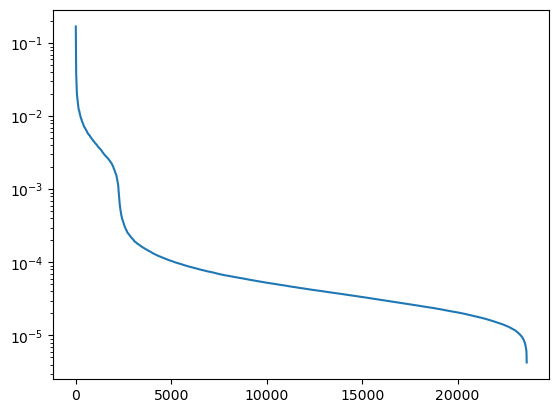

In [66]:
#Plot distances
plt.plot(range(len(train_feats)-2), selector.get_select_distance()[1:])
plt.yscale('log')

PCovFPS suggests maybe using 6000 or so structures is not an awful idea, in order to balance computational burden with accuracy.

# Small Hyperparam Optimisation

In [14]:
#Small loop for SOAP hypers optimisation
for rc in [4,6,8]:
    for n in [6,9,12]:
        for l in [4,6,8]:
            hypers['interaction_cutoff'] = rc
            hypers['max_radial'] = n
            hypers['max_angular'] = l
            soap=SphericalInvariants(**hypers)
            
            feats_t = get_features(train_frames[:10000], batch_size=250)
            feats_v = get_features(val_frames, batch_size=250)
            
            model = Ridge(fit_intercept=False, alpha=1e-4)
            model.fit(feats_t, y_small[:3750])
            
            predictions = model.predict(feats_v)
            errors = predictions - y_small[3750:]
            rmse = np.sqrt(np.mean(np.abs(errors)))
            
            print(f"RMSE using rc={rc}, n={n}, l={l} : {np.round(rmse, 6)} eV")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=6, l=4 : 1.043688 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=6, l=6 : 1.025771 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=6, l=8 : 1.014872 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=9, l=4 : 1.042269 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=9, l=6 : 1.018662 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=9, l=8 : 1.009446 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=12, l=4 : 1.037987 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=12, l=6 : 1.014619 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=4, n=12, l=8 : 1.003798 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=6, l=4 : 1.023154 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=6, l=6 : 1.011613 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=6, l=8 : 0.995652 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=9, l=4 : 1.012423 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=9, l=6 : 1.000087 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=9, l=8 : 0.985657 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=12, l=4 : 1.007791 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=12, l=6 : 0.994335 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=6, n=12, l=8 : 0.978967 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=6, l=4 : 1.065337 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=6, l=6 : 1.048606 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=6, l=8 : 1.032453 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=9, l=4 : 1.013074 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=9, l=6 : 0.991521 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=9, l=8 : 0.96705 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=12, l=4 : 0.993759 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=12, l=6 : 0.977424 eV


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RMSE using rc=8, n=12, l=8 : 0.961028 eV


In [33]:
#Loop for soap hyperparameter optimisation
n_train = 10000

results=[]
count=0; 

#Iterate over interaction cuttoff
for rc in [4.,6.,8.]:
    hypers['interaction_cutoff']=rc
    
    #Iterate over nmax
    for n in [6,9,12]:
        hypers['max_radial'] = n
        
        #Iterate over lmax
        for l in [4,6,8]:
            start = time()
            hypers['max_angular'] = l
            soap = SphericalInvariants(**hypers) #redefine soap with new parameters
            #print("Iteration: ", count+1, "/ 36") #keep count of iteration
            train_feat=get_features(train_frames[:n_train], batch_size=250) #get features for training set
            val_feat=get_features(val_frames, batch_size=250) #get features for validation set
            count+=1
            
            #Normalise feature vectors
            for feat in train_feat:
                feat/=np.linalg.norm(feat)
            for feat in val_feat:
                feat/=np.linalg.norm(feat)

            #Iterate over zeta values
            for zeta in [2.,3.]:
                K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
                Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance matrix for validation

                #Iterate over regularization values
                minerr = 1e24 ; minreg = 0
                for reg in np.logspace(-9,-5,5):
                    KRR = KernelRidge(kernel='precomputed',alpha = reg)
                    KRR.fit(K,yred_train[:n_train])
                    err = np.std(yred_val - KRR.predict(Kval))
                    if err < minerr:
                        minerr = err.copy()
                        minreg = reg.copy()
                results.append([minerr, rc, n, l, zeta, minreg])
            print(f"Results using rc={rc}, n={n}, l={l}, zeta={zeta}, minreg={minreg}:")
            print(f"Error = {minerr} eV/atom")
            print('Time taken: ',time()-start)
            print("---------------------------------------------------------------------------------")

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003336002785217394 eV/atom
Time taken:  81.88889241218567
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003309462061763038 eV/atom
Time taken:  99.24900221824646
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0032783918274639783 eV/atom
Time taken:  121.45538020133972
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0032924446824565655 eV/atom
Time taken:  105.38145017623901
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, zeta=3.0, minreg=1e-05:
Error = 0.0032649808755064024 eV/atom
Time taken:  143.81601977348328
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0032512236768953103 eV/atom
Time taken:  184.834636926651
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=12, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0032930356919597618 eV/atom
Time taken:  145.25313425064087
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=12, l=6, zeta=3.0, minreg=1e-05:
Error = 0.0032722603862221813 eV/atom
Time taken:  198.4149661064148
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=12, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0032584151023967835 eV/atom
Time taken:  260.11613631248474
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0032617533834723555 eV/atom
Time taken:  134.26059556007385
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003215413070008251 eV/atom
Time taken:  174.0540931224823
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=8, zeta=3.0, minreg=1e-05:
Error = 0.003210622761523323 eV/atom
Time taken:  223.2677764892578
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003140881433231713 eV/atom
Time taken:  165.3098120689392
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003066097290216129 eV/atom
Time taken:  234.3080632686615
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=8, zeta=3.0, minreg=1e-05:
Error = 0.003024141312240806 eV/atom
Time taken:  316.5952978134155
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=12, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003171357614468681 eV/atom
Time taken:  209.14312887191772
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=12, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003110579247998621 eV/atom
Time taken:  303.42199516296387
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=12, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0030911986715829935 eV/atom
Time taken:  417.37284874916077
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=6, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003399377945394419 eV/atom
Time taken:  237.00242948532104
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=6, l=6, zeta=3.0, minreg=1e-05:
Error = 0.0033572883659647762 eV/atom
Time taken:  318.25767993927
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=6, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0033466552653936645 eV/atom
Time taken:  419.1527421474457
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=9, l=4, zeta=3.0, minreg=1e-05:
Error = 0.003151610598964201 eV/atom
Time taken:  279.24709582328796
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=9, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003099843288946592 eV/atom
Time taken:  407.04337430000305
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=9, l=8, zeta=3.0, minreg=1e-05:
Error = 0.003078392411355435 eV/atom
Time taken:  572.6248948574066
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=12, l=4, zeta=3.0, minreg=1e-05:
Error = 0.0031401645944787475 eV/atom
Time taken:  332.01562762260437
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=12, l=6, zeta=3.0, minreg=1e-05:
Error = 0.003049739647829518 eV/atom
Time taken:  504.2500720024109
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=8.0, n=12, l=8, zeta=3.0, minreg=1e-05:
Error = 0.0030186421370690794 eV/atom
Time taken:  719.6348259449005
---------------------------------------------------------------------------------


In [34]:
np.save('delta_data/hyperparam_optimisation_results', np.asarray(results))

hyperopt=np.load('delta_data/hyperparam_optimisation_results.npy')

# Find optimal hyperparameters, which correspond to the lowest error
hyperopt[np.where(hyperopt==np.amin(hyperopt, axis=0)[0])[0]]

array([[3.01864214e-03, 8.00000000e+00, 1.20000000e+01, 8.00000000e+00,
        3.00000000e+00, 1.00000000e-05]])

In [37]:
#Loop for soap hyperparameter optimisation
n_train = 10000

results_gauss=[]
count=0; 

#Iterate over interaction cuttoff
for rc in [4.,6.]:
    hypers['interaction_cutoff']=rc
    
    #Iterate over nmax
    for n in [6,9]:
        hypers['max_radial'] = n
        
        #Iterate over lmax
        for l in [4,6]:
            hypers['max_angular'] = l
            
            for gauss in [0.2, 0.3, 0.4, 0.5]:
                hypers['gaussian_sigma_constant'] = gauss
                start = time()
                soap = SphericalInvariants(**hypers) #redefine soap with new parameters
                #print("Iteration: ", count+1, "/ 36") #keep count of iteration
                train_feat=get_features(train_frames[:n_train], batch_size=250) #get features for training set
                val_feat=get_features(val_frames, batch_size=250) #get features for validation set
                count+=1

                #Normalise feature vectors
                for feat in train_feat:
                    feat/=np.linalg.norm(feat)
                for feat in val_feat:
                    feat/=np.linalg.norm(feat)

                #Iterate over zeta values
                for zeta in [2.,3.]:
                    K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
                    Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance matrix for validation

                    #Iterate over regularization values
                    minerr = 1e24 ; minreg = 0
                    for reg in np.logspace(-9,-5,5):
                        KRR = KernelRidge(kernel='precomputed',alpha = reg)
                        KRR.fit(K,yred_train[:n_train])
                        err = np.std(yred_val - KRR.predict(Kval))
                        if err < minerr:
                            minerr = err.copy()
                            minreg = reg.copy()
                    results_gauss.append([minerr, rc, n, l, gauss, zeta, minreg])
                    print(f"Results using rc={rc}, n={n}, l={l}, gauss={gauss}, zeta={zeta}, minreg={minreg}:")
                    print(f"Error = {minerr} eV/atom")
                    print('Time taken: ',time()-start)
                    print("---------------------------------------------------------------------------------")

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.003728977991732251 eV/atom
Time taken:  63.87083435058594
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.2, zeta=3.0, minreg=1e-06:
Error = 0.003576528211944912 eV/atom
Time taken:  80.55424070358276
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.3, zeta=2.0, minreg=1e-06:
Error = 0.0036166181474782256 eV/atom
Time taken:  63.87961030006409
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0033889698697007952 eV/atom
Time taken:  80.61461138725281
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.003549099407193268 eV/atom
Time taken:  64.32818365097046
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.003336002784868447 eV/atom
Time taken:  82.16261625289917
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=4, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.0037128894050290806 eV/atom
Time taken:  64.00150656700134
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=4, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.0034275626045648694 eV/atom
Time taken:  80.72156190872192
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0036976709914159508 eV/atom
Time taken:  83.58781313896179
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=6, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0035725852951190617 eV/atom
Time taken:  100.76356601715088
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0034846661942808145 eV/atom
Time taken:  84.05329918861389
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=6, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.003309462061908323 eV/atom
Time taken:  101.18383646011353
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=6, l=6, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.003658610418059853 eV/atom
Time taken:  83.60352778434753
---------------------------------------------------------------------------------
Results using rc=4.0, n=6, l=6, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.003412604069560694 eV/atom
Time taken:  100.80333542823792
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.003815873052860442 eV/atom
Time taken:  87.32802510261536
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0035562213182211526 eV/atom
Time taken:  105.26402187347412
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.003535903802687005 eV/atom
Time taken:  87.23755931854248
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0033029906099550366 eV/atom
Time taken:  105.12631726264954
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0034650605592127636 eV/atom
Time taken:  86.97673606872559
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.003292444682437117 eV/atom
Time taken:  104.92616653442383
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=4, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.00364215864163527 eV/atom
Time taken:  87.0994029045105
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=4, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.003403551188596302 eV/atom
Time taken:  105.03994250297546
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0037678140116025076 eV/atom
Time taken:  125.46758389472961
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.003499873693294303 eV/atom
Time taken:  144.21193408966064
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.0034573842947204936 eV/atom
Time taken:  125.05274844169617
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0032609378688749843 eV/atom
Time taken:  143.77879929542542
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0033996236782084187 eV/atom
Time taken:  125.60542297363281
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0032649808757396577 eV/atom
Time taken:  144.4166488647461
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=4.0, n=9, l=6, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.003580896273935685 eV/atom
Time taken:  124.93761348724365
---------------------------------------------------------------------------------
Results using rc=4.0, n=9, l=6, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.0033832598177934107 eV/atom
Time taken:  143.74483132362366
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0034574663414286807 eV/atom
Time taken:  116.72413444519043
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0032649672184883595 eV/atom
Time taken:  133.46645092964172
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.003406373233342118 eV/atom
Time taken:  117.00523805618286
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.003227737847416436 eV/atom
Time taken:  133.80000710487366
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.0034372034556241684 eV/atom
Time taken:  117.32609033584595
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0032617533833880453 eV/atom
Time taken:  134.08903741836548
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=4, gauss=0.5, zeta=2.0, minreg=1e-06:
Error = 0.0035585300086519653 eV/atom
Time taken:  117.02691316604614
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=4, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.003352396382342394 eV/atom
Time taken:  133.7808394432068
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.2, zeta=2.0, minreg=1e-05:
Error = 0.00340793370117842 eV/atom
Time taken:  158.044917345047
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.003263660118312655 eV/atom
Time taken:  175.13648104667664
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.003341927045182621 eV/atom
Time taken:  158.81839752197266
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.003197866449004104 eV/atom
Time taken:  175.93037915229797
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.003392474210433983 eV/atom
Time taken:  159.90526819229126
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0032154130695879932 eV/atom
Time taken:  177.08552813529968
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=6, l=6, gauss=0.5, zeta=2.0, minreg=1e-05:
Error = 0.003540718200147211 eV/atom
Time taken:  158.31112790107727
---------------------------------------------------------------------------------
Results using rc=6.0, n=6, l=6, gauss=0.5, zeta=3.0, minreg=1e-05:
Error = 0.0033165529925520834 eV/atom
Time taken:  175.49212217330933
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, gauss=0.2, zeta=2.0, minreg=1e-06:
Error = 0.0034316815827771076 eV/atom
Time taken:  147.99601340293884
---------------------------------------------------------------------------------
Results using rc=6.0, n=9, l=4, gauss=0.2, zeta=3.0, minreg=1e-05:
Error = 0.0032509224111980026 eV/atom
Time taken:  165.97528624534607
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, gauss=0.3, zeta=2.0, minreg=1e-05:
Error = 0.0032436129398091436 eV/atom
Time taken:  147.89372992515564
---------------------------------------------------------------------------------
Results using rc=6.0, n=9, l=4, gauss=0.3, zeta=3.0, minreg=1e-05:
Error = 0.0031333298430689343 eV/atom
Time taken:  165.89367079734802
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using rc=6.0, n=9, l=4, gauss=0.4, zeta=2.0, minreg=1e-05:
Error = 0.003250605467293558 eV/atom
Time taken:  151.63241481781006
---------------------------------------------------------------------------------
Results using rc=6.0, n=9, l=4, gauss=0.4, zeta=3.0, minreg=1e-05:
Error = 0.0031408814332406394 eV/atom
Time taken:  169.55414390563965
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
np.save('delta_data/hyperparam_optimisation_results_gauss', np.asarray(results_gauss))

hyperopt=np.load('delta_data/hyperparam_optimisation_results_gauss.npy')

# Find optimal hyperparameters, which correspond to the lowest error
hyperopt[np.where(hyperopt==np.amin(hyperopt, axis=0)[0])[0]]

array([[3.06609729e-03, 6.00000000e+00, 9.00000000e+00, 6.00000000e+00,
        4.00000000e-01, 3.00000000e+00, 1.00000000e-05]])

Optimal hyperparameters (without expending computational efficiency too much) from both optimisations seem to be as follows:
- Cutoff = 6A
- nmax = 9
- lmax = 6
- gaussian sigma = 0.4
- zeta = 3

# PCovFPS Feature Selection

In [58]:
#Define soap hyperparameters
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)

In [27]:
#get per-structure training features
train_feats = get_features(train_frames, batch_size=250, progress_bar=True)

  0%|          | 0/95 [00:00<?, ?it/s]

In [67]:
#Do PCovFPS feature selection
selector = PCovFPS_features(mixing=0.3, initialize=0, progress_bar=True, n_to_select=len(train_feats.T)-1)
selector.fit(train_feats, yred_train)
pcf_feat_ids = selector.selected_idx_

  0%|          | 0/5668 [00:00<?, ?it/s]

In [68]:
#Save PCovFPS-sorted sample IDs
np.save('delta_data/pcovfps_features_selected_idx', pcf_feat_ids)

In [7]:
#Reload PCovFPS-sorted sample IDs
pcf_feat_ids = np.load('delta_data/pcovfps_features_selected_idx.npy')

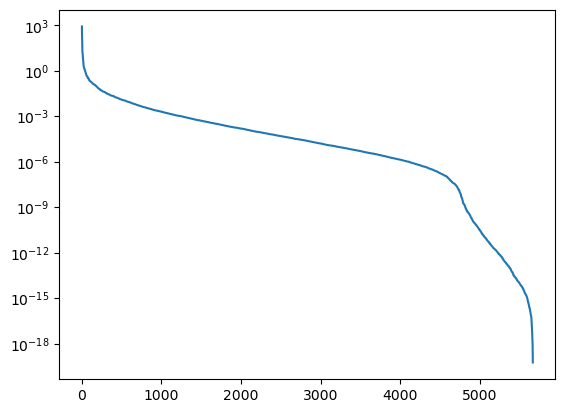

In [70]:
#Plot distances
plt.plot(range(len(train_feats.T)-2), selector.get_select_distance()[1:])
plt.yscale('log')

It seems like it may be best to use 1500 or so features, but this should really be investigated further by creating a loop to check how the regression error varies when changing the number of features. Should probably do the same for the number of training samples...

In [71]:
#Figure out which indices are mapped to which features
sp_pairs = soap.get_keys([1, 6, 7, 8])
mapping = get_power_spectrum_index_mapping(
    sp_pairs, n_max=hypers["max_radial"], l_max=hypers["max_angular"]+1 
) # +1 in lmax needed because of some Librascal bug (Rose said)

In [72]:
#Tell soap to only use indices from PCovFPS sorting
n_feats = 2000 #use this number of features
a = [mapping[i]['a'] for i in pcf_feat_ids[:n_feats]]
b = [mapping[i]['b'] for i in pcf_feat_ids[:n_feats]]
n1 = [mapping[i]['n1'] for i in pcf_feat_ids[:n_feats]]
n2 = [mapping[i]['n2'] for i in pcf_feat_ids[:n_feats]]
l = [mapping[i]['l'] for i in pcf_feat_ids[:n_feats]]

soap = SphericalInvariants(**hypers, coefficient_subselection={"a": a, "b": b, "n1": n1, "n2":n2, "l":l})

# Optimise No. of Samples and Features

In [91]:
#Loop for determining optimal numbers of samples and features...
results=[]

val_feat=get_features(val_frames, batch_size=250) #get features for validation set

#Iterate n_samples
for samples in range(5000, 16000, 1000):
        start = time()
        n_train=samples
        train_feat=get_features(train_frames[:n_train], batch_size=250) #get features for training set

        #Normalise feature vectors
        for feat in train_feat:
            feat/=np.linalg.norm(feat)
        for feat in val_feat:
            feat/=np.linalg.norm(feat)

        K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
        Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance matrix for validation

        #Iterate over regularization values
        minerr = 1e24 ; minreg = 0
        for reg in np.logspace(-9,-5,5):
            KRR = KernelRidge(kernel='precomputed',alpha = reg)
            KRR.fit(K,yred_train[:n_train])
            err = np.std(yred_val - KRR.predict(Kval))
            if err < minerr:
                minerr = err.copy()
                minreg = reg.copy()
        results.append([minerr, n_train, minreg])
        print(f"Results using n_samples={n_train}, minreg={minreg}:")
        print(f"Error = {minerr} eV/atom")
        print('Time taken: ',time()-start)
        print("---------------------------------------------------------------------------------")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Results using n_samples=5000, minreg=1e-05:
Error = 0.004792773360393965 eV/atom
Time taken:  73.68238711357117
---------------------------------------------------------------------------------


  0%|          | 0/24 [00:00<?, ?it/s]

Results using n_samples=6000, minreg=1e-05:
Error = 0.004421189386618893 eV/atom
Time taken:  89.77724957466125
---------------------------------------------------------------------------------


  0%|          | 0/28 [00:00<?, ?it/s]

Results using n_samples=7000, minreg=1e-05:
Error = 0.0039426817191584975 eV/atom
Time taken:  104.81004047393799
---------------------------------------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Results using n_samples=8000, minreg=1e-05:
Error = 0.0037081932842559307 eV/atom
Time taken:  124.07098412513733
---------------------------------------------------------------------------------


  0%|          | 0/36 [00:00<?, ?it/s]

Results using n_samples=9000, minreg=1e-05:
Error = 0.003307952209091278 eV/atom
Time taken:  138.6951506137848
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Results using n_samples=10000, minreg=1e-05:
Error = 0.0031412263659494313 eV/atom
Time taken:  157.31473755836487
---------------------------------------------------------------------------------


  0%|          | 0/44 [00:00<?, ?it/s]

Results using n_samples=11000, minreg=1e-05:
Error = 0.0029088746390765413 eV/atom
Time taken:  176.7822301387787
---------------------------------------------------------------------------------


  0%|          | 0/48 [00:00<?, ?it/s]

Results using n_samples=12000, minreg=1e-06:
Error = 0.00277789588880742 eV/atom
Time taken:  196.33304381370544
---------------------------------------------------------------------------------


  0%|          | 0/52 [00:00<?, ?it/s]

Results using n_samples=13000, minreg=1e-06:
Error = 0.002678318742259399 eV/atom
Time taken:  219.1603808403015
---------------------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Results using n_samples=14000, minreg=1e-06:
Error = 0.002575530024026604 eV/atom
Time taken:  236.31686067581177
---------------------------------------------------------------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

Results using n_samples=15000, minreg=1e-06:
Error = 0.0024711339580227353 eV/atom
Time taken:  256.3306174278259
---------------------------------------------------------------------------------


In [92]:
#Save and re-load results
np.save('delta_data/nsamples_optimisation_results', np.asarray(results))
results=np.load('delta_data/nsamples_optimisation_results.npy')

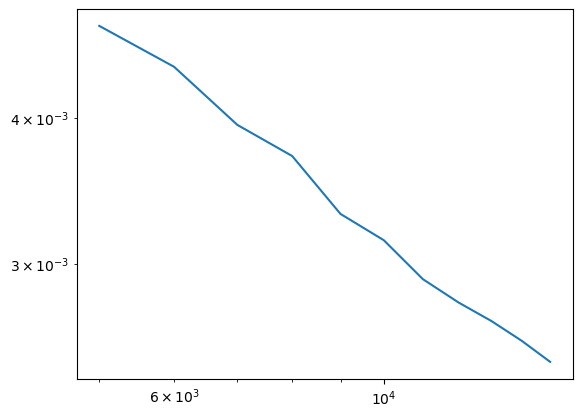

In [93]:
#Plot learning curve
plt.plot(results[:, 1], results[:, 0])
plt.yscale('log')
plt.xscale('log')

Looks like th elearning curve hasn't really saturated yet. However, in order to minimise the size of the model, let's just use 15k samples and not increase it any further. 

In [100]:
#Loop for determining optimal numbers of features
feat_results = []
n_train = 10000 #use this number of training points
#Iterate n_features
for n_feats in tqdm(range(1000, 6000, 500), leave=False):
            start = time()
            
            a = [mapping[i]['a'] for i in pcf_feat_ids[:n_feats]]
            b = [mapping[i]['b'] for i in pcf_feat_ids[:n_feats]]
            n1 = [mapping[i]['n1'] for i in pcf_feat_ids[:n_feats]]
            n2 = [mapping[i]['n2'] for i in pcf_feat_ids[:n_feats]]
            l = [mapping[i]['l'] for i in pcf_feat_ids[:n_feats]]

            soap = SphericalInvariants(**hypers, 
                                       coefficient_subselection={"a": a, "b": b, "n1": n1, "n2":n2, "l":l})

            
            train_feat=get_features(train_frames[:n_train], batch_size=250) #get features for training set
            val_feat=get_features(val_frames, batch_size=250) #get features for validation set
            
            #Normalise feature vectors
            for feat in train_feat:
                feat/=np.linalg.norm(feat)
            for feat in val_feat:
                feat/=np.linalg.norm(feat)

            K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
            Kval = np.dot(val_feat,train_feat.T)**zeta #compute covariance matrix for validation

            #Iterate over regularization values
            minerr = 1e24 ; minreg = 0
            for reg in np.logspace(-9,-5,5):
                KRR = KernelRidge(kernel='precomputed',alpha = reg)
                KRR.fit(K,yred_train[:n_train])
                err = np.std(yred_val - KRR.predict(Kval))
                if err < minerr:
                    minerr = err.copy()
                    minreg = reg.copy()
            feat_results.append([minerr, n_feats, minreg])
            print(f"Results using n_feats={n_feats}, minreg={minreg}:")
            print(f"Error = {minerr} eV/atom")
            print('Time taken: ',time()-start)
            print("---------------------------------------------------------------------------------")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=1000, minreg=1e-05:
Error = 0.003286864916339273 eV/atom
Time taken:  160.24697065353394
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=1500, minreg=1e-05:
Error = 0.0031778816564641153 eV/atom
Time taken:  164.0591733455658
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=2000, minreg=1e-05:
Error = 0.003141226365318075 eV/atom
Time taken:  167.93182682991028
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=2500, minreg=1e-05:
Error = 0.003108626364750759 eV/atom
Time taken:  175.69061422348022
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=3000, minreg=1e-05:
Error = 0.0031032296853345086 eV/atom
Time taken:  182.95851230621338
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=3500, minreg=1e-05:
Error = 0.00310966322695215 eV/atom
Time taken:  189.1139476299286
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=4000, minreg=1e-05:
Error = 0.0031143243272121176 eV/atom
Time taken:  200.29438638687134
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=4500, minreg=1e-05:
Error = 0.0031121138155325357 eV/atom
Time taken:  208.34399151802063
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=5000, minreg=1e-05:
Error = 0.003092026506252423 eV/atom
Time taken:  216.8040292263031
---------------------------------------------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Results using n_feats=5500, minreg=1e-05:
Error = 0.0030919723551683736 eV/atom
Time taken:  224.88772201538086
---------------------------------------------------------------------------------


In [101]:
#Save and re-load results
np.save('delta_data/nfeatures_optimisation_results', np.asarray(feat_results))
feat_results=np.load('delta_data/nfeatures_optimisation_results.npy')

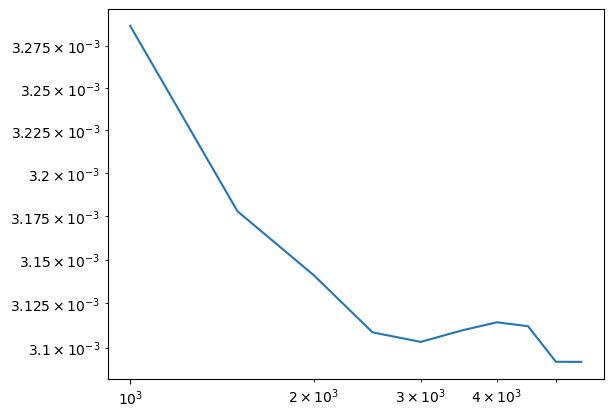

In [102]:
#Plot learning curve
plt.plot(feat_results[:, 1], feat_results[:, 0])
plt.yscale('log')
plt.xscale('log')

Seems like using 2500 features is enough, with minimal loss in accuracy.

# Create Model

In [48]:
#Define soap hyperparameters
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)

In [49]:
#Figure out which indices are mapped to which features
sp_pairs = soap.get_keys([1, 6, 7, 8])
mapping = get_power_spectrum_index_mapping(
    sp_pairs, n_max=hypers["max_radial"], l_max=hypers["max_angular"]+1 
) # +1 in lmax needed because of some Librascal bug (Rose said)

In [120]:
#Tell soap to only use indices from PCovFPS sorting
n_feats = 2500 #use this number of features (determined from the feature optimisation)
a = [mapping[i]['a'] for i in pcf_feat_ids[:n_feats]]
b = [mapping[i]['b'] for i in pcf_feat_ids[:n_feats]]
n1 = [mapping[i]['n1'] for i in pcf_feat_ids[:n_feats]]
n2 = [mapping[i]['n2'] for i in pcf_feat_ids[:n_feats]]
l = [mapping[i]['l'] for i in pcf_feat_ids[:n_feats]]

hypers['coefficient_subselection'] = {"a": a, "b": b, "n1": n1, "n2":n2, "l":l}
soap = SphericalInvariants(**hypers)
#soap = SphericalInvariants(**hypers, coefficient_subselection={"a": a, "b": b, "n1": n1, "n2":n2, "l":l})

In [53]:
#Create PCov-FPS sorted training database
n_train = 15000 #choose (optimal) number of training structures
pcf_train_frames = []; pcf_X_train=np.zeros((n_train, 4)); pcf_y_train=np.zeros(n_train); 

for ii, i in enumerate(pcf_ids[:n_train]):
    frm = train_frames[i]
    pcf_train_frames.append(frm)
    symbols = frm.get_atomic_numbers()
    pcf_X_train[ii] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    pcf_y_train[ii] = frm.info['Delta_energy']

pcf_yred_train = pcf_y_train/np.sum(pcf_X_train,axis=1)-mlr.predict(pcf_X_train)/np.sum(pcf_X_train,axis=1)

In [54]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(pcf_train_frames) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  271.1176245212555 s


In [55]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2000
nc = 2000
nn = 2000
no = 2000
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  637.1175303459167 s


In [56]:
dump_obj('delta_data/X_sparse_15k.json', X_sparse)

In [11]:
X_sparse = load_obj('delta_data/X_sparse_15k.json')

In [142]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(pcf_train_frames, desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
#Save kernel
np.save('delta_data/Knm_kernel_15k', Knm)

In [15]:
start = time()
print("Loading Knm...")
Knm = np.load('delta_data/Knm_kernel_15k.npy')
print("Knm loading time:", time()-start)

Loading Knm...
Knm loading time: 1779.0270457267761


In [ ]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, pcf_train_frames, Knm, X_sparse, pcf_y_train, y_dressed, 
                             grad_train=-get_forces(pcf_train_frames), lambdas=[0.05,1], 
                             jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

In [ ]:
#Save model
dump_obj('delta_data/GAP_model_15k_0.05_1.json', full_model)

In [ ]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_frames[:npred], desc = "Making predictions for validation set...", 
                                leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

y_val_pred = np.array(yvp).flatten()
f_val_pred = np.concatenate(fvp)

In [ ]:
np.save('delta_data/predictions/y_val_pred_15k', y_val_pred)
np.save('delta_data/predictions/f_val_pred_15k', f_val_pred)

In [13]:
npred=1000
y_val_pred = np.load('results_data/predictions/yval_pred_15k.npy')
f_val_pred = np.load('results_data/predictions/fval_pred_15k.npy')

In [153]:
rmse_energy = np.sqrt(np.mean(((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) 
                               - (y_val_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [154]:
rmse_forces = np.sqrt(np.mean((f_val.flatten()[:npred] - f_val_pred.flatten()[:npred])**2))

In [155]:
print('RMSE energy:', np.round(rmse_energy,6), 'eV/atom')
print('RMSE forces:', np.round(rmse_forces,6), 'eV/angstrom')

RMSE energy: 0.005141 eV/atom
RMSE forces: 0.18007 eV/angstrom


Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

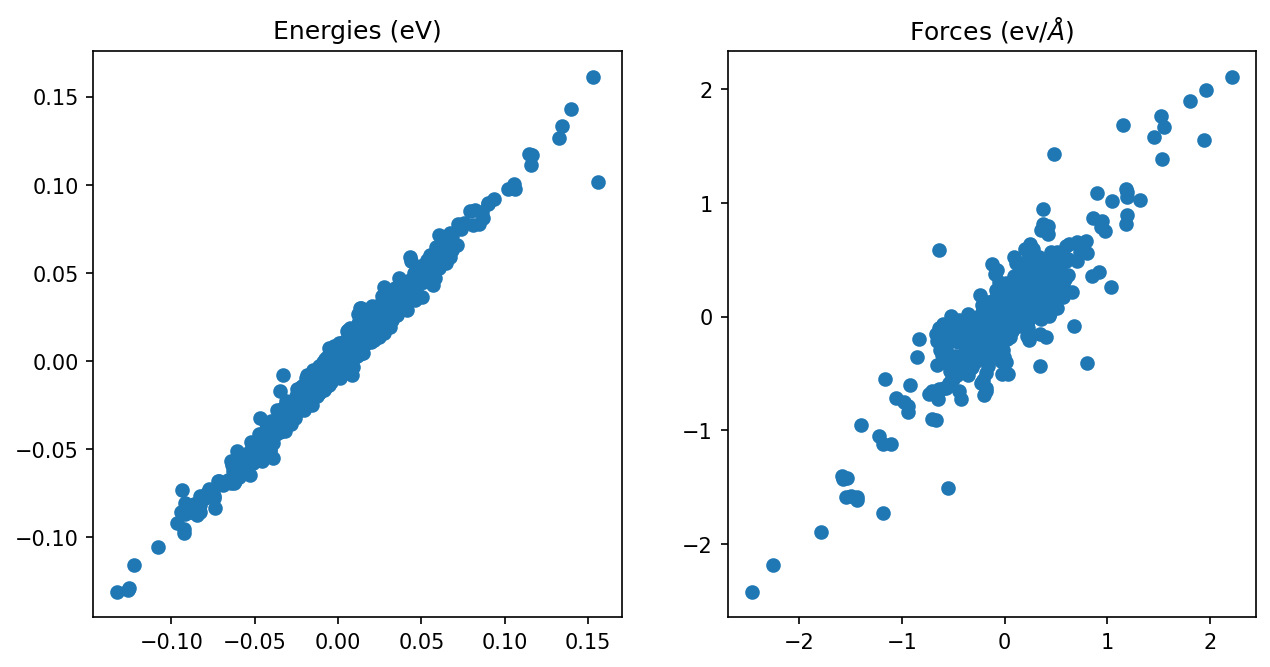

In [156]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=150)
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (y_val_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(f_val.flatten()[:npred], f_val_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [15]:
for i in range(1000,15000,1000):
    print('Creating model using', i, 'training structures...')
    nforce_rows = np.sum(nat_per_struct[:i])*3
    Kernelnm = np.zeros((i+nforce_rows, Knm.shape[1]))
    print('Computing kernel...')
    Kernelnm[:i] = Knm[:i]
    Kernelnm[i:] = Knm[ntrain:(ntrain+nforce_rows)]
    print('Creating model...')
    full_model = train_gap_model(kernel, train_set_FPS[:i], Kernelnm, X_sparse, ytrain_FPS[:i], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:i]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
    npred=1000
    yvp = []
    fvp = []

    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    np.save('results_data/yval_pred_lc_'+str(i), yval_pred)
    np.save('results_data/fval_pred_lc_'+str(i), fval_pred)
    print("Predictions saved.")
    rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    print('RMSE energy:', rmse_energy, 'eV/atom')
    print('RMSE forces:', rmse_forces, 'eV/angstrom')
    print("")

Creating model using 1000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.018605185747567955 eV/atom
RMSE forces: 0.374288145112019 eV/angstrom

Creating model using 2000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.010180187480841303 eV/atom
RMSE forces: 0.38900621538794705 eV/angstrom

Creating model using 3000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.007117896428504622 eV/atom
RMSE forces: 0.39074154333210837 eV/angstrom

Creating model using 4000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.006650503363529594 eV/atom
RMSE forces: 0.38974427987493065 eV/angstrom

Creating model using 5000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.00637998814212301 eV/atom
RMSE forces: 0.3908333615365183 eV/angstrom

Creating model using 6000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.006217729178197441 eV/atom
RMSE forces: 0.3873547382079486 eV/angstrom

Creating model using 7000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005969171250072053 eV/atom
RMSE forces: 0.38626271700082665 eV/angstrom

Creating model using 8000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.00577435914483878 eV/atom
RMSE forces: 0.38546857390970407 eV/angstrom

Creating model using 9000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.0056725263823453834 eV/atom
RMSE forces: 0.3839886377315317 eV/angstrom

Creating model using 10000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005573389811260722 eV/atom
RMSE forces: 0.3814997985532318 eV/angstrom

Creating model using 11000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005525750486718551 eV/atom
RMSE forces: 0.382403325089767 eV/angstrom

Creating model using 12000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005465802088514222 eV/atom
RMSE forces: 0.3828256188916966 eV/angstrom

Creating model using 13000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005443024140781266 eV/atom
RMSE forces: 0.3815627201129578 eV/angstrom

Creating model using 14000 training structures...
Computing kernel...
Creating model...


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Predictions saved.
RMSE energy: 0.005445800449234075 eV/atom
RMSE forces: 0.3840484906479948 eV/angstrom



In [ ]:
Knm[:nstructs] has the energy row of each structure 

Knm[nstructs:] has the force rows of each structure, which is organised as follows:
- There are natoms * 3 rows per structure
- Organised in the order of structures in nstruct
- i.e., to extract the force rows for structure with index 0, you have to figure out the number of atoms in that structure (e.g. 40), and multiply by 3, and then extract those indices from the end of the energy rows for all structures (as this is the structure with index 0). I.e. : Knm[nstruct:(nstruct+(40*3))]

np.save('raw_data/Knm_kernel_14k', Knm)
print("KNM saved")

Knm = np.load('raw_data/Knm_kernel_14k.npy')

#make list of number of atoms in each structure
nat_per_struct=[]
for frm in train_set_FPS[:ntrain]:
    nat_per_struct.append(len(frm))

#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_FPS[:ntrain], Knm, X_sparse, ytrain_FPS[:ntrain], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:ntrain]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
print("Time taken:", time()-start)

#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)

np.save('results_data/yval_pred_14k', yval_pred)
np.save('results_data/fval_pred_14k', fval_pred)

npred=1000
yval_pred = np.load('results_data/yval_pred_14k.npy')
fval_pred = np.load('results_data/fval_pred_14k.npy')

rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

print('RMSE energy:', rmse_energy, 'eV/atom')
print('RMSE forces:', rmse_forces, 'eV/angstrom')

for i in range(1000,15000,1000):
    print('Creating model using', i, 'training structures...')
    nforce_rows = np.sum(nat_per_struct[:i])*3
    Kernelnm = np.zeros((i+nforce_rows, Knm.shape[1]))
    print('Computing kernel...')
    Kernelnm[:i] = Knm[:i]
    Kernelnm[i:] = Knm[ntrain:(ntrain+nforce_rows)]
    print('Creating model...')
    full_model = train_gap_model(kernel, train_set_FPS[:i], Kernelnm, X_sparse, ytrain_FPS[:i], y_dressed, 
                        grad_train=-get_forces(train_set_FPS[:i]), lambdas=[0.055,3.25], jitter=1e-9, 
                        solver = 'RKHS')
    npred=1000
    yvp = []
    fvp = []

    for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
        manager_val = soap.transform(frm)
        yvp.append(full_model.predict(manager_val))
        fvp.append(full_model.predict_forces(manager_val))

    yval_pred = np.array(yvp).flatten()
    fval_pred = np.concatenate(fvp)
    np.save('results_data/yval_pred_lc_'+str(i), yval_pred)
    np.save('results_data/fval_pred_lc_'+str(i), fval_pred)
    print("Predictions saved.")
    rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))
    rmse_forces = np.sqrt(np.mean((fval_true.flatten()[:npred] - fval_pred.flatten()[:npred])**2))
    print('RMSE energy:', rmse_energy, 'eV/atom')
    print('RMSE forces:', rmse_forces, 'eV/angstrom')
    print("")